# MNIST Digit Generator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms as T

In [2]:
data_transforms = T.Compose([
  T.ToTensor(),
  T.Normalize((0.5, ), (0.5, ))
])

In [3]:
train_data = datasets.MNIST('data', train=True, download=True, transform=data_transforms)
test_data = datasets.MNIST('data', train=False, download=True, transform=data_transforms)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

linear_model_path = "models/lin-gan.pth"

In [6]:
def denorm(Y, mean=0.5, std=0.5):
  """Inverse the normalisation operation. The default values for mean and std are the values used in this notebook"""
  output = std * Y + mean
  return output.clamp(0, 1)

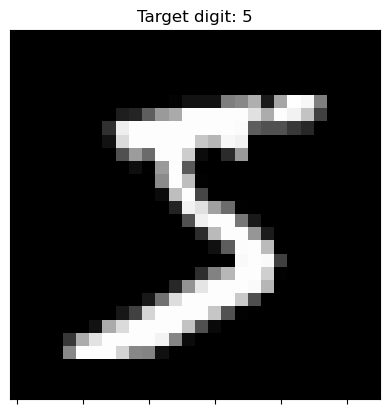

In [7]:
def plot_image(img, label=None, cmap='gray'):
  img = img.squeeze(0)
  plt.tick_params(left=False, bottom=True, labelleft=False, labelbottom=False)

  if label is not None:
    plt.title("Target digit: " + str(label))
  plt.imshow(img, cmap=cmap)


plot_image(denorm(train_data[0][0]), train_data[0][1])

In [8]:
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size, shuffle=False, num_workers=2)

Number of batches: 469


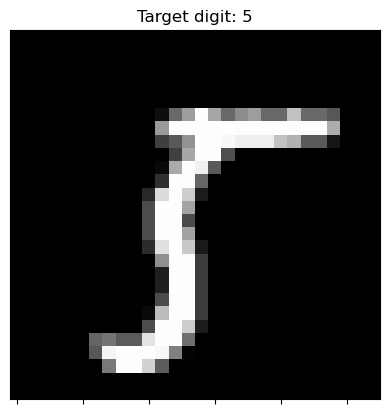

In [9]:
def check_dataloader(dloader):
  for images, labels in train_loader:
    plot_image(images[0].numpy(), labels[0].item())

    break

check_dataloader(train_loader)
print(f"Number of batches: {len(train_loader)}")

In [10]:
# def create_small_loader(large_loader, num_batches):
#   """Creates a small loader, it will have `num_batches` batches with size `batch_size`"""
#   small_loader = []

#   for i, xy_pair in enumerate(large_loader):
#     if (i == num_batches): break

#     small_loader.append(xy_pair)

#   return small_loader

# train_loader = create_small_loader(train_loader, 2)
# len(train_loader)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Designing the GAN

##### Desigining the Discriminator

In [12]:
class Discriminator(nn.Module):

  def __init__(self, image_size, hidden_size):
    super(Discriminator, self).__init__()

    self.image_size, self.hidden_size = image_size, hidden_size

    self.lin1 = nn.Linear(image_size, hidden_size)
    self.lrelu = nn.LeakyReLU(0.2)
    self.bn1 = nn.BatchNorm1d(hidden_size)

    self.lin2 = nn.Linear(hidden_size, hidden_size)
    self.lin3 = nn.Linear(hidden_size, 1)

    
  def forward(self, X):
    # X = self.bn1(self.lrelu(self.lin1(X)))
    # X = self.bn1(self.lrelu(self.lin2(X)))
    X = self.lrelu(self.lin1(X))
    X = self.lrelu(self.lin2(X))
    return torch.sigmoid(self.lin3(X))

  def __repr__(self) -> str:
    return f"Linear({self.image_size}, {self.hidden_size}) -> LeakyReLU(0.02) ->\nLinear({self.hidden_size}, {self.hidden_size}) -> LeakyReLU(0.02) ->\nLinear({self.hidden_size}, 1) -> Sigmoid()"


In [13]:
image_size, hidden_size = 784, 256
disc = Discriminator(image_size, hidden_size)
disc.to(device)

Linear(784, 256) -> LeakyReLU(0.02) ->
Linear(256, 256) -> LeakyReLU(0.02) ->
Linear(256, 1) -> Sigmoid()

##### Designing the Generator

In [14]:
class Generator(nn.Module):

  def __init__(self, latent_size, hidden_size, image_size):
    super(Generator, self).__init__()
    self.lin1 = nn.Linear(latent_size, hidden_size)
    self.lrelu = nn.ReLU()

    self.lin2 = nn.Linear(hidden_size, hidden_size)
    self.lin3 = nn.Linear(hidden_size, image_size)


  def forward(self, X):
    X = self.lrelu(self.lin1(X))
    X = self.lrelu(self.lin2(X))
    return torch.tanh(self.lin3(X))

In [15]:
latent_size = 64
gen = Generator(latent_size, hidden_size, image_size)
gen.to(device)

Generator(
  (lin1): Linear(in_features=64, out_features=256, bias=True)
  (lrelu): ReLU()
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=784, bias=True)
)

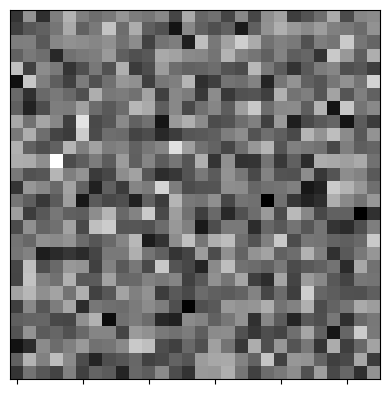

In [16]:
# testing out the generator
y = gen(torch.randn((1, latent_size), device=device))
plot_image(denorm( y.reshape(1, 28, 28)).detach().cpu().numpy())

### Training the Discriminator

In [17]:
def reset_grad(optims):
  for optim in optims:
    optims[optim].zero_grad()

In [18]:
def get_accuracy_binary(outputs, target_class):
  """Returns num_correct"""
  len_outputs = outputs.size(0)
  num_correct = (torch.round(outputs) == target_class).sum()
  return num_correct.item()


In [19]:
a = torch.rand((3, 1))
a, get_accuracy_binary(a, 1)

(tensor([[0.5179],
         [0.9062],
         [0.6121]]),
 3)

In [20]:
def train_discriminator(images, disc, gen, optimizers, criterion):
  """Returns the following for each minibatch: `(loss, real_score, fake_score)`"""

  # batch_size is redefined because len of images might be redefined somewhere else
  batch_size = len(images)

  real_labels = torch.ones((batch_size, 1), device=device)
  fake_labels = torch.zeros((batch_size, 1), device=device)

  # train on real data, discriminator should aim to predict 1
  outputs = disc(images)
  d_real = criterion(outputs, real_labels)
  # we set target class to 1 below, because discriminator's accuracy on real images should be based on 1
  real_score = get_accuracy_binary(outputs, 1)

  # train on fake data, discriminator should aim to predict 0
  Z = torch.randn((batch_size, latent_size), device=device)
  fake_images = gen(Z)

  outputs = disc(fake_images)
  # we set target class to 0 below, because discriminator's accuracy on fake images should be based on 0
  d_fake = criterion(outputs, fake_labels)
  fake_score = get_accuracy_binary(outputs, 0)

  d_loss = d_real + d_fake

  reset_grad(optimizers)
  d_loss.backward()
  nn.utils.clip_grad_norm_(disc.parameters(), 1)

  optimizers["disc"].step()

  return d_loss, real_score, fake_score

### Training the Generator

In [21]:
def train_generator(disc, gen, optimizers, loss):
  """Returns the following for 1 minibatch: `(loss, fake_images)`. This loss is the loss attributed to the amount of images that the generator produced that got classified as fake. This will aim to improve the generator."""
  real_labels = torch.ones((batch_size, 1), device=device)

  Z = torch.randn((batch_size, latent_size), device=device)
  fake_images = gen(Z)

  disc_preds = disc(fake_images)

  # fake_score = get_accuracy_binary(disc_preds, 1)

  # generator has to try and fool the discriminator
  # try and make the discriminator predict 1 for actually fake images
  d_loss = loss(disc_preds, real_labels)

  reset_grad(optimizers)
  d_loss.backward()
  nn.utils.clip_grad_norm_(disc.parameters(), 1)
  nn.utils.clip_grad_norm_(gen.parameters(), 1)
  
  optimizers['gen'].step()

  return d_loss, fake_images

##### Utilites for visualisation of images

In [22]:
real_samples_dir, fake_samples_dir = 'samples/real', 'samples/fake'

for dir in [real_samples_dir, fake_samples_dir]:
  os.makedirs(dir, exist_ok=True)

In [23]:
from IPython.display import Image
from torchvision.utils import save_image, make_grid

n_rows, n_cols = 8, 8


def save_real_images(loader):

  real_grid_path = os.path.join(real_samples_dir, 'real_grid.png')

  # if real image grid exists, don't make it again
  if os.path.exists(real_grid_path):
    return

  # we will save a grid of real images
  for images, labels in loader:
    images = denorm(images)
    grid_image = make_grid(images, n_rows).permute(1, 2, 0)
    plot_image(grid_image, "Grid of real images")
    print("Saving above real grid of images")
    save_image(images, real_grid_path, n_rows=n_rows)
    break


In [24]:
sample_latent_vector = torch.randn((batch_size, latent_size), device=device)

def save_fake_images(index):
  gen_images = gen(sample_latent_vector)

  target_shape = (sample_latent_vector.size(0), 1, 28, 28)
  gen_images = denorm(gen_images).reshape(target_shape)
  fake_grid_path = os.path.join(fake_samples_dir, f"fake_{index:04d}.png")
  save_image(gen_images, fake_grid_path, n_rows=n_rows)

save_fake_images(0)

### Training of the entire network

In [25]:
criterion = nn.BCELoss()
lr = 0.0002

optimizers = {
  "disc": torch.optim.Adam(disc.parameters(), lr=lr),
  "gen": torch.optim.Adam(gen.parameters(), lr=lr)
}

In [26]:
from math import floor

def init_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0)

def train_network(disc, gen, train_loader, optimizers, loss, num_epochs, train_if_exists=False):

  disc.apply(init_weights)
  
  starting_epoch = 0

  if os.path.exists(linear_model_path):
    checkpoint = torch.load(linear_model_path)
    disc.load_state_dict(checkpoint["disc_state_dict"])
    gen.load_state_dict(checkpoint["gen_state_dict"])
    loss = checkpoint["criterion"]
    starting_epoch = checkpoint["epoch"]

  d_losses, g_losses, real_scores, fake_scores = [], [], [], []

  for epoch in range(starting_epoch, num_epochs ):

    print(f"Epoch [{epoch} | {num_epochs}]: ")

    for i, ( images, labels ) in enumerate( train_loader ):

      images = images.reshape(images.size(0), -1).to(device)

      d_loss, real_score, fake_score = train_discriminator(images, disc, gen, optimizers, loss)
      g_loss, fake_images = train_generator(disc, gen, optimizers, loss)

    print(f"\t d_loss: {d_loss}, g_loss: {g_loss}, D(X): {real_score}, D(G(z)): {fake_score}")

    d_losses.append(d_loss)
    g_losses.append(g_loss)
    real_scores.append(real_score)
    fake_scores.append(fake_score)
    
    if epoch % 3 == 0:
      print(f"Saving the fake images for the epoch {epoch}")
      save_fake_images(epoch)

  
  return d_losses, g_losses, real_scores, fake_scores


train_network(disc, gen, train_loader, optimizers, criterion, 600);

Epoch [187 | 600]: 
	 d_loss: 1.5834379196166992, g_loss: 1.05126953125, D(X): 49, D(G(z)): 51
Epoch [188 | 600]: 
	 d_loss: 2.2828643321990967, g_loss: 0.5175380706787109, D(X): 59, D(G(z)): 16
Epoch [189 | 600]: 
	 d_loss: 2.07662296295166, g_loss: 0.48934727907180786, D(X): 67, D(G(z)): 18
Saving the fake images for the epoch 189
Epoch [190 | 600]: 
	 d_loss: 0.8039531707763672, g_loss: 2.006746292114258, D(X): 71, D(G(z)): 87
Epoch [191 | 600]: 
	 d_loss: 1.0864113569259644, g_loss: 1.4285824298858643, D(X): 71, D(G(z)): 64
Epoch [192 | 600]: 
	 d_loss: 1.5496337413787842, g_loss: 0.8370823264122009, D(X): 73, D(G(z)): 37
Saving the fake images for the epoch 192
Epoch [193 | 600]: 
	 d_loss: 1.8668965101242065, g_loss: 0.6383513808250427, D(X): 60, D(G(z)): 30
Epoch [194 | 600]: 


KeyboardInterrupt: 

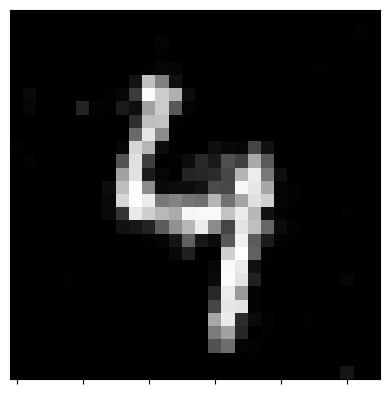

In [ ]:
Z = torch.randn((1, latent_size), device=device)
plot_image(gen(Z).reshape(28, 28).detach().cpu())

### Saving our model

In [ ]:
torch.save({
  "epoch": 187,
  "disc_state_dict": disc.state_dict(),
  "gen_state_dict": gen.state_dict(),
  "criterion": criterion
}, linear_model_path)